In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from tqdm import tqdm_notebook as tqdm
import tensorflow.keras as keras
import shutil

In [2]:
cell_types = ['basophil', 'ig', 'lymphocyte', 'platelet', 'neutrophil', 'eosinophil', 'erythroblast', 'monocyte', 'garbage']

In [3]:
means = np.array([0.7211705 , 0.74826562, 0.87347637])
stds = np.array([0.07981221, 0.18539167, 0.1585313 ])
cutoff = 800000

In [4]:
model_path = 'densenet_cellclass.hdf5'

In [5]:
data_root = '/hddraid5/data/colin/covid-data/COVID Research Images/'
output_root = '/hddraid5/data/colin/covid-data/wbc_classified/'
all_image_paths = glob.glob(os.path.join(data_root, '**/*.jpg'), recursive=True)
image_paths = [image_path for image_path in all_image_paths if (os.path.getsize(image_path) < cutoff and os.path.getsize(image_path) > 100)]

In [6]:
model = keras.models.load_model(model_path)

In [7]:
images = []
for imp in tqdm(image_paths):
    image = cv.imread(imp)
    image = cv.resize(image, (224, 224)) / 255
    image = (image - means)/stds
    images.append(image)
images = np.array(images)

/home/colin/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [8]:
labels = model.predict(images,batch_size=16, verbose=1)

20431/20431 [==============================] - 59s 3ms/sample


Text(0.5, 1.0, 'Confidence: 0.0245% low confidence')

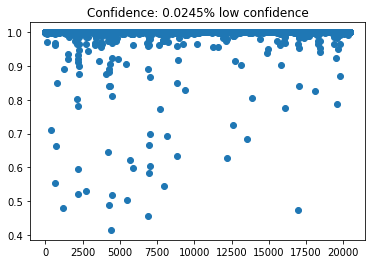

In [9]:
conf = np.max(labels, axis=1)
plt.scatter(np.arange(0, len(conf)), conf)
plt.title(f"Confidence: {100*len(conf[conf<0.5])/len(conf):.4f}% low confidence")

In [10]:
low_confidence_inds = np.arange(0, len(conf))[conf < 0.5]
display_indices = np.random.choice(low_confidence_inds, size=5*4, replace=False)
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15,19))
fig.suptitle("low confidence samples", fontsize=32, y=0.95)
for i in range(5):
    for j in range(4):
        ind = display_indices[i*4 + j]
        axs[i,j].imshow(cv.cvtColor(cv.imread(image_paths[ind]), cv.COLOR_BGR2RGB))
        label = f'{cell_labels[ind]}'
        label += f'\nconfidence of {100*conf[ind]:.3f}%'
        axs[i,j].set_title(label)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

ValueError: Cannot take a larger sample than population when 'replace=False'

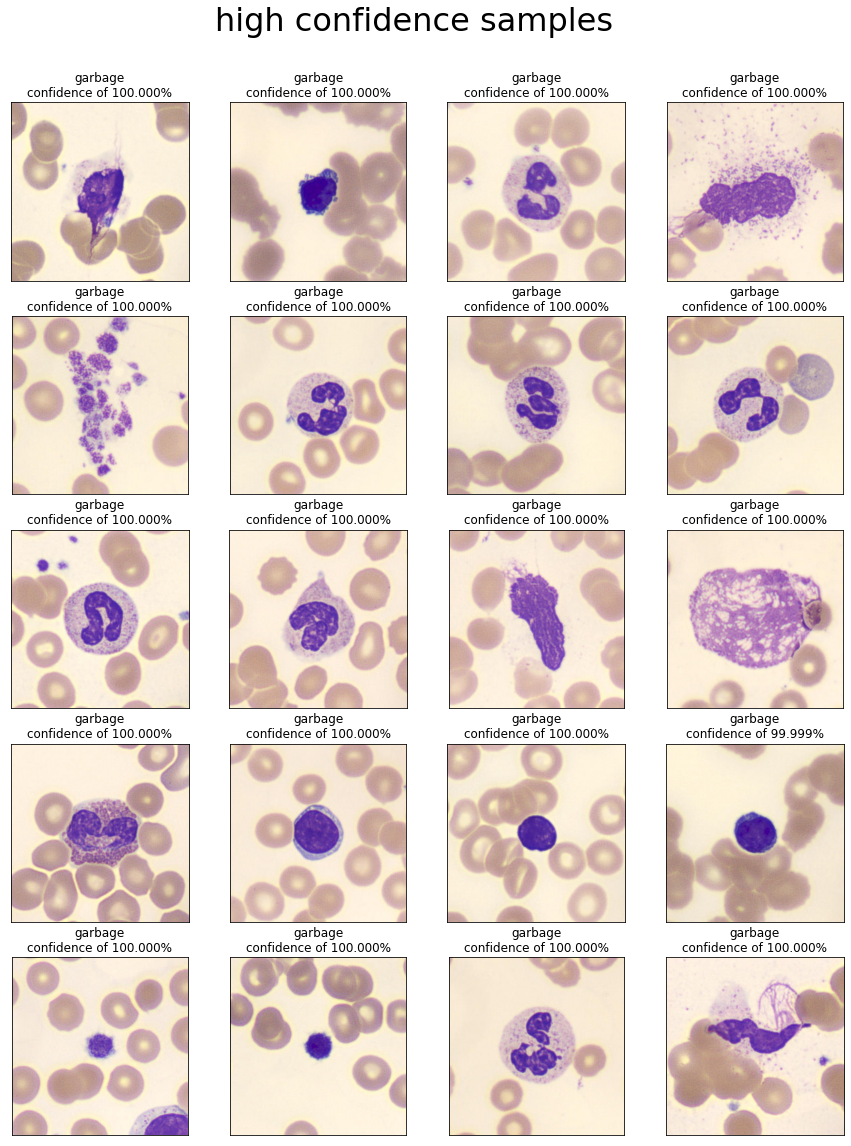

In [14]:
high_confidence_inds = np.arange(0, len(conf))[conf > 0.5]
display_indices = np.random.choice(high_confidence_inds, size=5*4, replace=False)
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15,19))
fig.suptitle("high confidence samples", fontsize=32, y=0.95)
for i in range(5):
    for j in range(4):
        ind = display_indices[i*4 + j]
        axs[i,j].imshow(cv.cvtColor(cv.imread(image_paths[ind]), cv.COLOR_BGR2RGB))
        label = f'{cell_labels[ind]}'
        label += f'\nconfidence of {100*conf[ind]:.3f}%'
        axs[i,j].set_title(label)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

In [12]:
cell_labels = np.array(cell_types)[np.argmax(labels, axis=1)]

In [96]:
for cell_label, image_path, confidence in tqdm(zip(cell_labels, image_paths, conf)):
    if confidence > 0.60:
        patient_id = image_path.split('/')[-2]
        image_name = os.path.basename(image_path)
        new_path = os.path.join(output_root, patient_id, cell_label, image_name)
        os.makedirs(new_path, exist_ok=True)
        shutil.copy2(image_path, new_path)